# PLRデータ分析例 - LINEデータ

PLRに保存したデータの取得例です。

本環境は [Jupyter Notebook](https://jupyter.org/) の形で構成されており、[Pythonスクリプト](https://www.python.jp/)を用いて記述しています。

ライブラリは公式イメージ [jupyter/scipy-notebook](https://jupyter-docker-stacks.readthedocs.io/en/latest/using/selecting.html#jupyter-scipy-notebook) のものがインストールされています。

# このデータ分析例が想定するタスク

このデータ分析例は、LINEとGO-E-MONのやり取りから得られたデータのうち、**被験者本人のPersonaryに格納されるデータ** の分析方法を対象としています。

https://goemon.cloud/t/7Px9TLbLICeCb2bKj19f

# チャンネルの取得

処理したいデータが格納されたチャンネルを取得します。GO-E-MONにより格納されたデータを処理したい場合は、 `cog-pds-log` となります。


> Jupyter Notebook Serverの起動直後など、実行がなかなか終わらない状態になる可能性があります。
> 実行状態が `[*]` のまま先に進まない場合は 中断(■) を押して一旦中断し、再度実行してみてください。

In [1]:
import asyncio
from plrfs.rpc_client import PLRFSClient

# クライアントライブラリを初期化
loop = asyncio.get_event_loop()

client = await PLRFSClient(loop).connect()

# チャンネル一覧を取得
channels = await client.get_files([])
for ch in channels:
    print('Channel', repr(ch['name']))

Channel 'family'
Channel 'coworkers'
Channel 'friends'
Channel 'ログ'
Channel 'ログスキーマ'
Channel 'テスト１'
Channel 'cog-pds-log'
Channel 'テスト(from googleDrive:yazawa@voice-research.com)'


参照したいチャンネル名を以下に記述します。

In [2]:
channel_name = 'cog-pds-log'
channel_name

'cog-pds-log'

In [3]:
channels = await client.get_files([])
cogtask_me_chs = [c for c in channels if c['name'] == channel_name]
assert len(cogtask_me_chs) > 0, 'cogtask.meのチャンネルが見つかりません。'
cogtask_me_ch = cogtask_me_chs[0]
cogtask_me_ch

{'kind': 'folder', 'id': '20211102075548_UKqR', 'name': 'cog-pds-log'}

データの読み込みは `PLRFSClient`から実施できます。これは以下のような関数を持っています。

In [4]:
help(client)

Help on PLRFSClient in module plrfs.rpc_client object:

class PLRFSClient(builtins.object)
 |  PLRFSClient(loop)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, loop)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  async connect(self, host='tcp://localhost:5555')
 |  
 |  async get_file(self, path)
 |  
 |  async get_files(self, path)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



ファイルシステムを模した構造になっていて、 `client.get_files` で指定したチャンネル、アイテムの配下のアイテム一覧を取得することができます。また、`client.get_file` で指定したチャンネル、アイテムの配下のデータを取得することができます。


# LINEデータの取得

試しに、チャンネルからLINEで得られたデータを取り出してみましょう。

In [13]:
import re

# 正規表現で、処理対象とするアイテムの名前のパターンを定義する
item_pattern = re.compile(r'^LINE画像連携サンプル:.*$')
item_pattern

re.compile(r'^LINE画像連携サンプル:.*$', re.UNICODE)

In [14]:
import json
import pandas as pd

timeline_item_data = []
# チャンネル内のアイテムを取得する
timeline_items = await client.get_files([cogtask_me_ch['id']])

for item in timeline_items:
    print('Processing...', item['id'])
    # アイテムのプロパティを取得する
    timeline_properties = await client.get_files([cogtask_me_ch['id'], item['id']])
    if 'cogPDSJSON' not in [p['name'] for p in timeline_properties]:
        continue
    assert 'cnt' in [p['name'] for p in timeline_properties]
    summary = await client.get_file([cogtask_me_ch['id'], item['id'], [p['id'] for p in timeline_properties if p['name'] == 'cnt'][0]])
    summary_s = summary['content'].decode('utf8')
    if not item_pattern.match(summary_s):
        continue
    
    assert 'begin' in [p['name'] for p in timeline_properties]
    begin = await client.get_file([cogtask_me_ch['id'], item['id'], [p['id'] for p in timeline_properties if p['name'] == 'begin'][0]])
    begin_s = begin['content'].decode('utf8')
    
    if 'cogPDSUser' in [p['name'] for p in timeline_properties]:
        cogPDSUser = await client.get_file([cogtask_me_ch['id'], item['id'], [p['id'] for p in timeline_properties if p['name'] == 'cogPDSUser'][0]])
    else:
        cogPDSUser = None

    user_s = cogPDSUser['content'].decode('utf8') if cogPDSUser is not None else None
    
    cogPDSJSON = await client.get_file([cogtask_me_ch['id'], item['id'], [p['id'] for p in timeline_properties if p['name'] == 'cogPDSJSON'][0]])
    data = json.loads(cogPDSJSON['content'])
    timeline_item_data.append((summary_s, begin_s, user_s, data))

df = pd.DataFrame(timeline_item_data, columns=['Summary', 'Time', 'User', 'Detail'])
df

Processing... #20211102075628_QYFv
Processing... #20211104051707_YkQs
Processing... #20211216033506_4xjl
Processing... #20211216033906_4oU4
Processing... #20211218022807_7VbR
Processing... #20211218023232_BLUW
Processing... #20211228015806_xVhM
Processing... #20220318044510_gbpQ
Processing... #20220402090436_0PiI
Processing... #20220402092905_1Hgv
Processing... #20220402093206_rILv
Processing... #20220407125222_fGQ7
Processing... #20220407125217_tcA0
Processing... #20220407125212_b6Tc
Processing... #20220407125226_8uLs
Processing... #20220407125207_HYZs
Processing... #20220407125306_vv18
Processing... #20220408050838_3mwf
Processing... #20220408050906_9r0U
Processing... #20220418133508_fJO6
Processing... #20221006101307_EJfS
Processing... #20221006101507_fQ-N
Processing... #20221006101511_rKTE
Processing... #20221006101807_t7Wi
Processing... #20221006101818_xF9l
Processing... #20221006102107_I7IM
Processing... #20221006102112_FWLU
Processing... #20221006102406_vNof
Processing... #20221

,Summary,Time,User,Detail
0,LINE画像連携サンプル: メッセージを受信しました。,2024-04-29T22:34:04.825Z,bpM7G6D8YrnoxyKVHAwz,{'meta': {'task': {'id': '7Px9TLbLICeCb2bKj19f...
1,LINE画像連携サンプル: メッセージを受信しました。,2024-04-29T22:37:03.279Z,bpM7G6D8YrnoxyKVHAwz,{'meta': {'task': {'id': '7Px9TLbLICeCb2bKj19f...
2,LINE画像連携サンプル: アンケートに回答しました。,2024-04-29T22:37:03.279Z,bpM7G6D8YrnoxyKVHAwz,{'meta': {'task': {'id': '7Px9TLbLICeCb2bKj19f...
3,LINE画像連携サンプル: メッセージを送信しました。,2024-04-29T22:37:03.279Z,bpM7G6D8YrnoxyKVHAwz,{'meta': {'task': {'id': '7Px9TLbLICeCb2bKj19f...
4,LINE画像連携サンプル: メッセージを受信しました。,2024-04-29T22:38:20.185Z,bpM7G6D8YrnoxyKVHAwz,{'meta': {'task': {'id': '7Px9TLbLICeCb2bKj19f...
5,LINE画像連携サンプル: メッセージを送信しました。,2024-04-29T22:38:20.185Z,bpM7G6D8YrnoxyKVHAwz,{'meta': {'task': {'id': '7Px9TLbLICeCb2bKj19f...
6,LINE画像連携サンプル: メッセージを受信しました。,2024-04-29T22:38:36.886Z,bpM7G6D8YrnoxyKVHAwz,{'meta': {'task': {'id': '7Px9TLbLICeCb2bKj19f...
7,LINE画像連携サンプル: メッセージを送信しました。,2024-04-29T22:38:36.886Z,bpM7G6D8YrnoxyKVHAwz,{'meta': {'task': {'id': '7Px9TLbLICeCb2bKj19f...
8,LINE画像連携サンプル: アンケートに回答しました。,2024-04-29T22:38:36.886Z,bpM7G6D8YrnoxyKVHAwz,{'meta': {'task': {'id': '7Px9TLbLICeCb2bKj19f...


dfにはLINEで得られたデータが全て格納されます。

受信したデータのみを得るためには、Summaryが「メッセージを受信しました」となっている項目を参照してください。

In [17]:
# 正規表現で検索
df[df['Summary'].str.match(r'.*受信しました.*')]

,Summary,Time,User,Detail
0,LINE画像連携サンプル: メッセージを受信しました。,2024-04-29T22:34:04.825Z,bpM7G6D8YrnoxyKVHAwz,{'meta': {'task': {'id': '7Px9TLbLICeCb2bKj19f...
1,LINE画像連携サンプル: メッセージを受信しました。,2024-04-29T22:37:03.279Z,bpM7G6D8YrnoxyKVHAwz,{'meta': {'task': {'id': '7Px9TLbLICeCb2bKj19f...
4,LINE画像連携サンプル: メッセージを受信しました。,2024-04-29T22:38:20.185Z,bpM7G6D8YrnoxyKVHAwz,{'meta': {'task': {'id': '7Px9TLbLICeCb2bKj19f...
6,LINE画像連携サンプル: メッセージを受信しました。,2024-04-29T22:38:36.886Z,bpM7G6D8YrnoxyKVHAwz,{'meta': {'task': {'id': '7Px9TLbLICeCb2bKj19f...


このようにして、Personary上のデータをメモリに読み込むことができます。これらの内容を**暗号化等をかけていないファイル等に出力する際は十分に取り扱いに注意**してください。

各データの `Detail` にはログが記録されています。

In [20]:
df[df['Summary'].str.match(r'.*受信しました.*')]['Detail'].values[-1]

{'meta': {'task': {'id': '7Px9TLbLICeCb2bKj19f', 'title': 'LINE画像連携サンプル'},
  'started': None,
  'recorded': 1714430316886,
  'finished': None,
  'duration': None},
 'data': {'received': {'source': {'type': 'pseudonymized',
    'userId': 'bpM7G6D8YrnoxyKVHAwz',
    'taskId': '7Px9TLbLICeCb2bKj19f'},
   'message': {'type': 'text',
    'id': '505999177189687633',
    'quoteToken': 'dDcG6aoXu-hbqib-Sie_4bc-fFNiHr1_wLgvILFdulqnXRXoXo96WORuVZmhPVOuMnuL0Cm4MhXWA-KPaAVf3ARWiGl8mu0C7b9jP54fv9r-5kvYb4eaUtMuLRPqNuzbpGBdd9hTxaxVS3TMyN-ueQ',
    'text': 'テストです'}}}}

画像は、受信データのうち message.type が 'image' の場合に、message.imageDataURLとして格納されています。

```
data: {
  received: {
    message: {
      imageDataURL: (DATA URL)
    }
  }
}
```

コードの記述はChatGPTに聞いても良いかもしれません。

['',
 '']
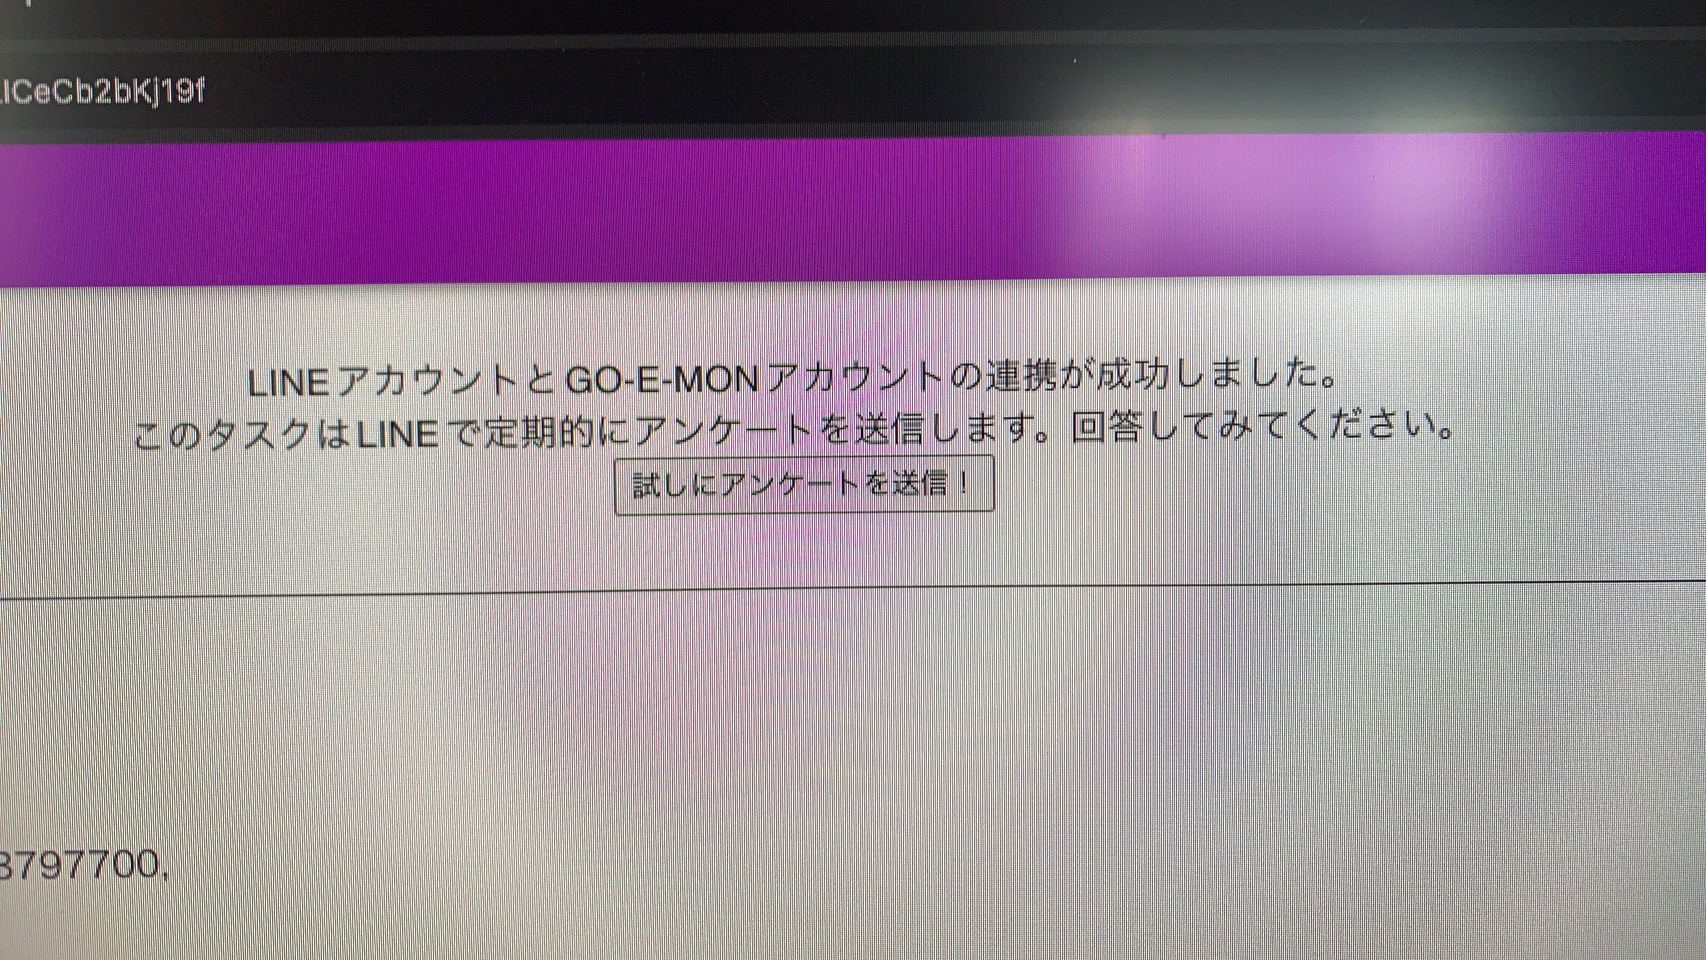
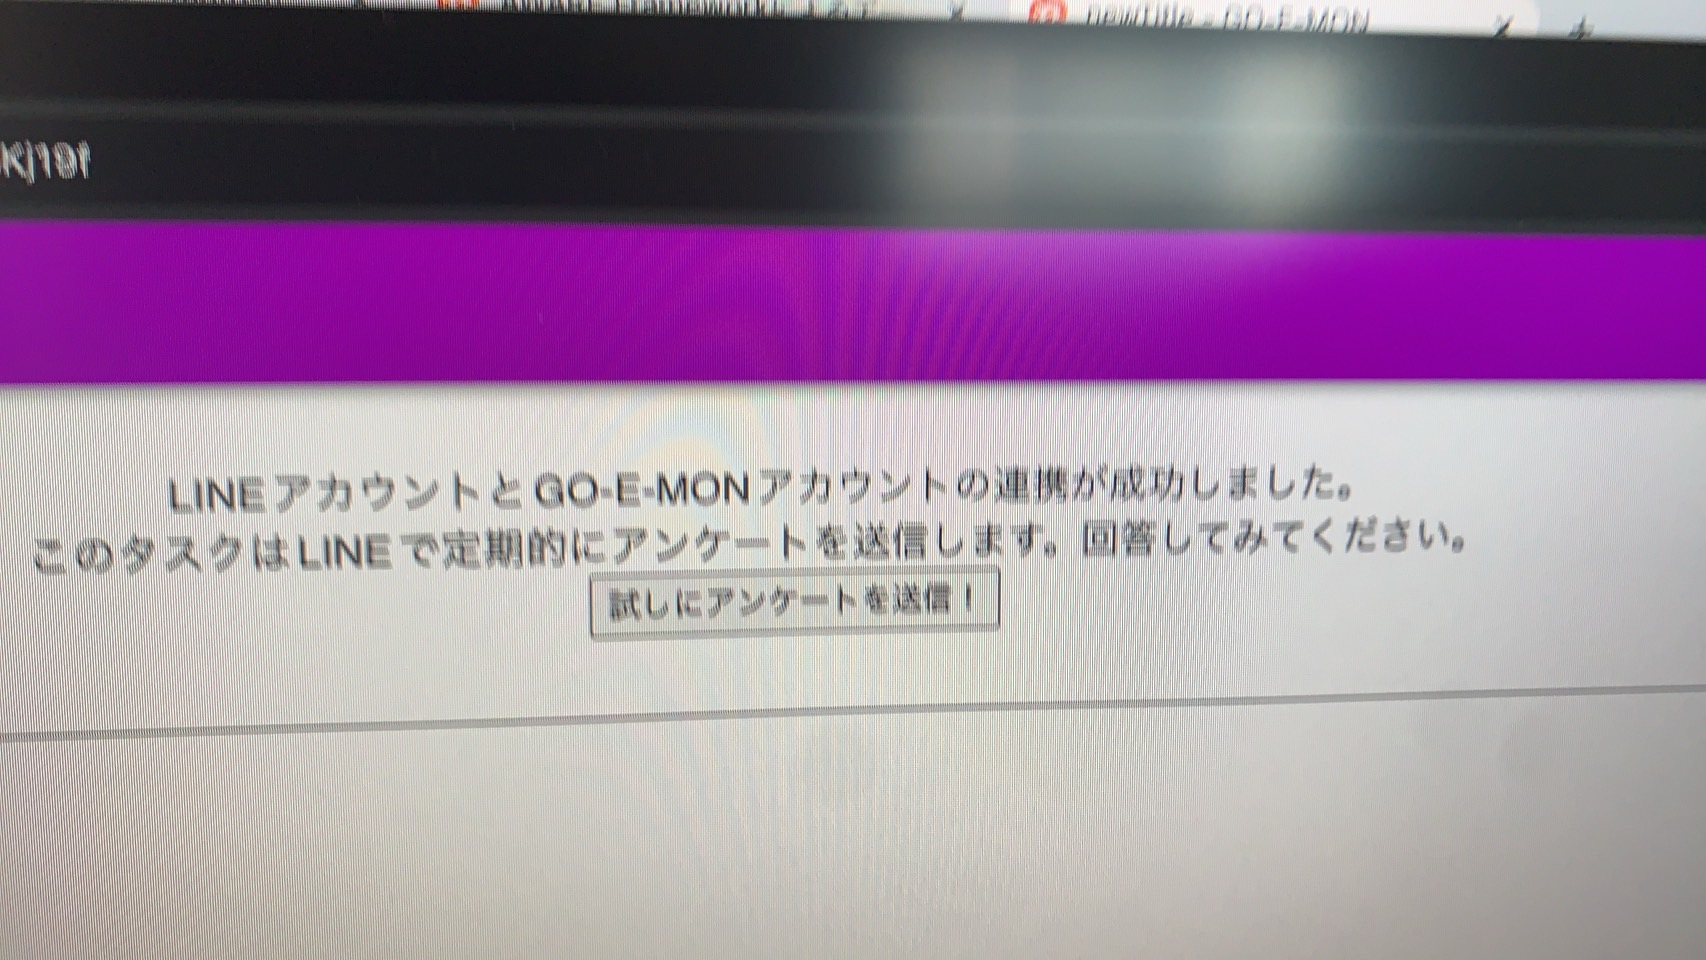

In [23]:
messages = [v['data']['received']['message'] if 'received' in v['data'] else None for v in df[df['Summary'].str.match(r'.*受信しました.*')]['Detail'].values]
urls = [message['imageDataURL'] for message in messages if 'imageDataURL' in message]
urls

抽出されたData URLは、以下のコードで表示できます。

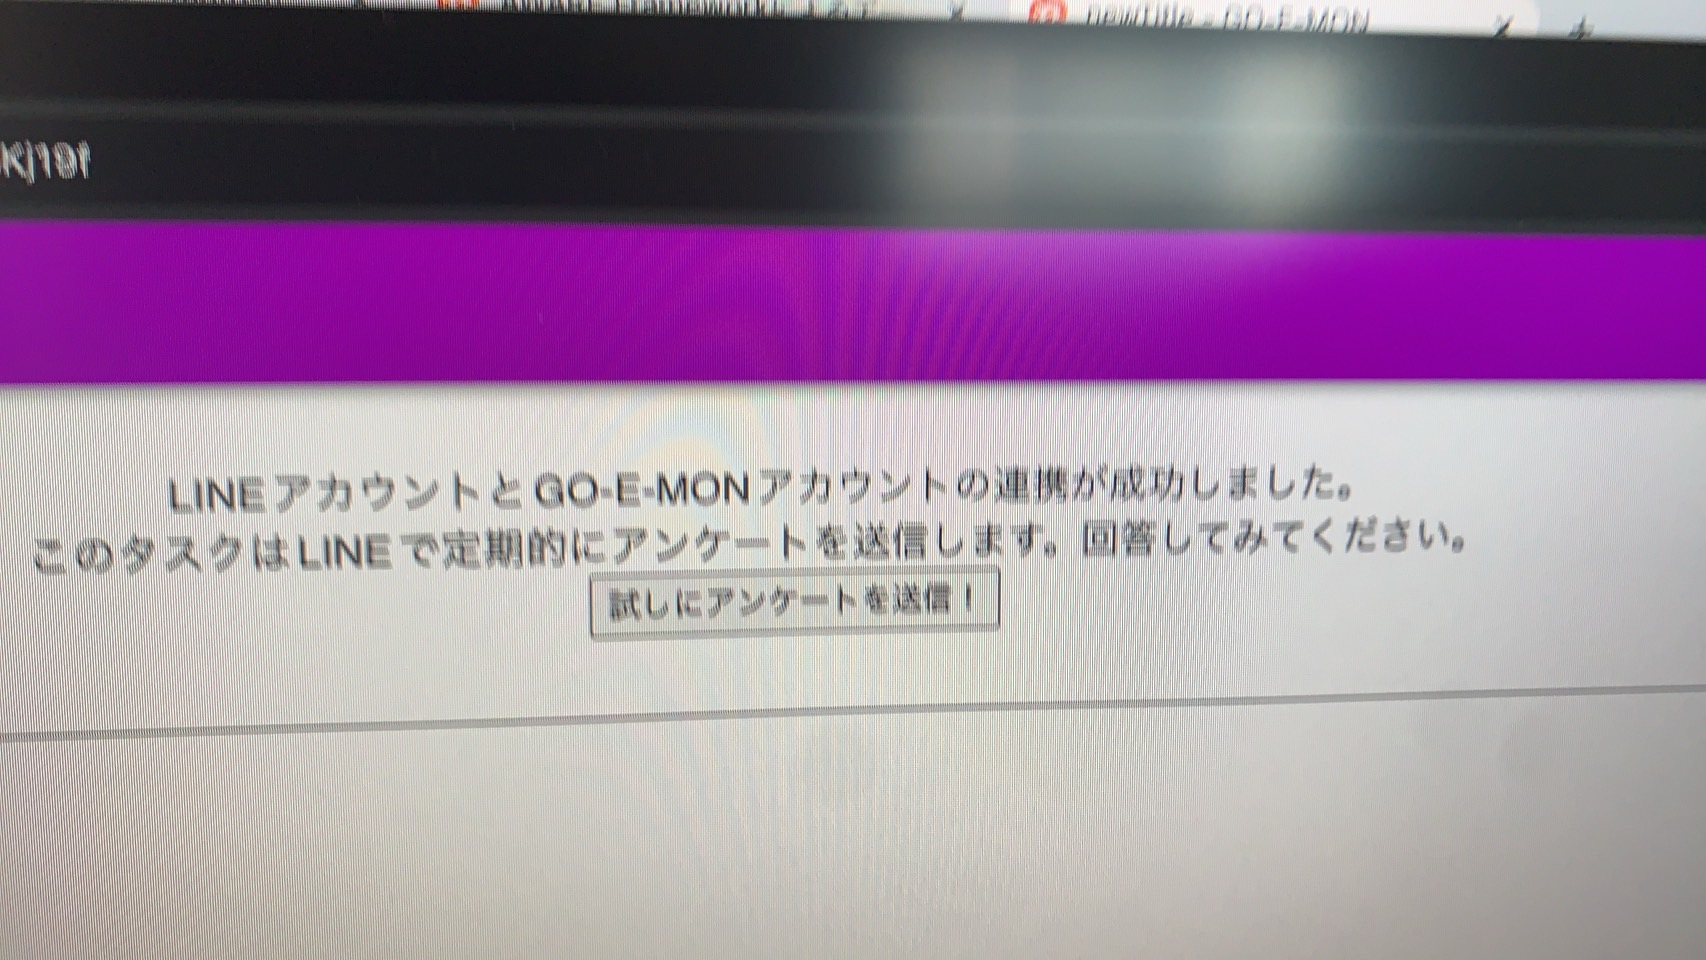

In [26]:
from IPython.display import display, Image
import base64

# 表示対象の画像
data_url = urls[-1]

# Data URLから画像データの部分だけを抽出し、バイトデータにデコードします
image_data = data_url.split(',')[1]
image_bytes = base64.b64decode(image_data)

# Imageクラスを使用して画像を表示
display(Image(image_bytes))